## PH4044 Tutorial 3

In [56]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pde 
from scipy.integrate import odeint

### Question 1

#### NOTES TO MYSELF
- Question seems to allow use to vary $\eta_f$. The challenge is going to be comming up with a suitable scale. 
- $E$ / $eta$ we can intentionally set to a specific value I think and vary $\eta_f$ around it.

In [3]:
# Define all constants
T = 23 + 273.15 # K
m_0 = 9.109E-31 # kg
k_B = 1.381E-23 # J/K
hbar = 1.055E-34

In [4]:
# Define the effective concentration
def N_c(m_e, T):
    return 2*((m_e*k_B*T)/(2*np.pi*hbar**2))**(3/2)

# Define the Fermi Integral
def F_half(eta_f):
    F_half_values = []
    for eta_value in eta_f:
        integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))
        F_half_values.append(integrate.quad(integrand, 0, np.inf)[0])
    return np.array(F_half_values)
    

# Define the n using the Fermi-dirac distribution (via the Fermi-Integral)
def n_f(eta_f, m_e, T):
    return (2/np.sqrt(np.pi))*N_c(m_e, T)*F_half(eta_f)

# Define n using the Boltzmann Approximation
def n_b(eta_f, m_e, T):
    return N_c(m_e, T)*np.exp(eta_f)

In [5]:
N_c(m_0, T)

2.4590479124116217e+25

### NOTES TO MYSELF
- The reason I've got these crazy values is because I'm totally ignoring the scale of $E_f$, $E_c$ and $kT$ when generating my $\eta_f$ values. 
- I need to generate values that are on the correct order of magnitude. 
- I would also generally expect $\eta_f < 0$ if the fermi energy is lower than the conduction band energy (which it should be in almost every case bar maybe doping). 

/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_1047/4081472078.py:9: RuntimeWarning: overflow encountered in exp
  integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))


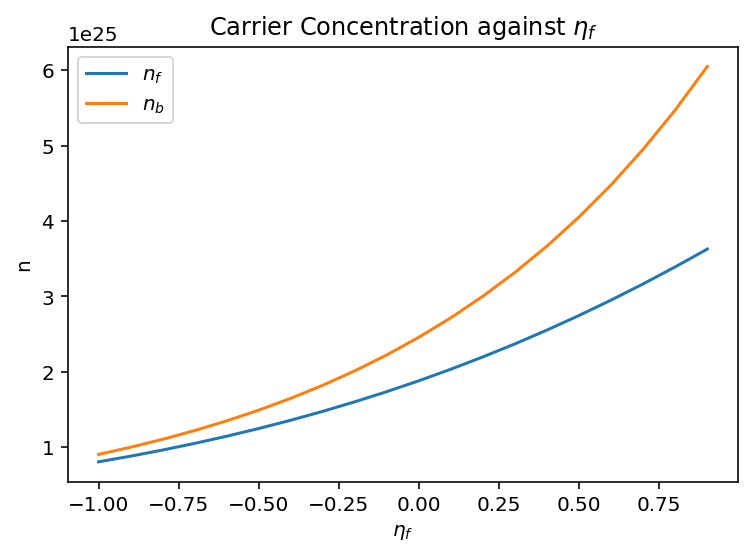

In [10]:
# Plot n_b against n_f 
eta_f = np.arange(-1, 1, 0.1)

fig = plt.figure(dpi=144)
plt.plot(eta_f, n_f(eta_f, m_0, T), label='$n_f$')
plt.plot(eta_f, n_b(eta_f, m_0, T), label='$n_b$')
plt.xlabel("$\eta_f$")
plt.ylabel("n")
plt.title("Carrier Concentration against $\eta_f$")
plt.legend()

For $E_F = E_C - 100\text{meV}$ and $E_F = E_C + 50 \text{meV}$, we find $\eta_f$ is given by $\eta_f = -100 \text{meV} /k_BT$ and $\eta_f = +50 \text{meV} /k_B T$ respectively. We find the corresponding carrier concentrations to be given by

In [11]:
# For eta_f = eta_C - 100
eta_f_1 = np.array([- (100 * 1e-3 * 1.6e-19) / (k_B * T)])
n_f_1 = n_f(eta_f_1, m_0, T)


/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_1047/4081472078.py:9: RuntimeWarning: overflow encountered in exp
  integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))


### Question 2

#### NOTES TO MYSELF
Okay, what do I need to do here?

a) State whether the semiconductor is n-type or p-type 
    - $V_H$ is negative, which suggests work is done by the electric field in moving positive charge in the direction idicated by the arrow on the diagram
    - This suggests a build up of negative charge on the top plate or a build up of positive charge on the bottom plate 
    - Given both electrions and holes will be forced onto the bottom plate by the magnetic field, we thus conclude an excess of holes. It is a p-type dopant. (However, given the equations in the slides, I would imagine the negative sign indicates a build-up of electrons)

b) I imagine there is some sort of equation for that 
    - 

c) Can we equate current density to the current and sub in the value we've been given for D_p? Wait, that includes the temperature. Maybe we could assume room temp? Hmm, that might do-away with the neccessary assumptions for a Boltzmann dist approximation

### Question 3

What do I need to do? 

- Solve the differential equation using a differential equation solver 
- Plot the carrier density for different temperatures and applied electric fields
- Use the analytic solution to verify the results 

[ 5.00000000e+04 -4.87813952e+04  4.53009028e+04 ... -1.53840265e-08
  1.16033865e-08 -6.24789092e-09]


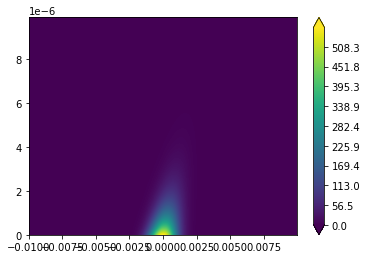

In [94]:
'''
FFT Method for solving PDEs
Code adapted from Steve Burton's 'Solving PDEs with the FFT [Python]' YouTube tutorial
Source: https://www.youtube.com/watch?v=hDeARtZdq-U
Accessed 13/03/23
'''
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 10000 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
k_B = 1.381e-23 # J/K
D_p = (mu_p * k_B * T) / e

# Define the alpha value we will use to scale both the x-axis and the 
# distribution of carriers 
alpha = 1e6

# Set up p-values to solve for 
N = 1000 # Number of data points 
x_bound = 1e-2
dx = 2*x_bound/N
x = np.arange(-x_bound, x_bound, dx)

# Define a discrete set of wavenumbers 
k = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial Conditions (assuming a normalised gaussian)
def amplitude(alpha, area=1):
    return area*np.sqrt(alpha/np.pi)
amp = amplitude(alpha)
p_0 = amp*np.exp(-alpha*x**2)
p_0_fft = np.fft.fft(p_0)

# Sort out issues from imaginary numbers
p_0_fft_ri = np.concatenate((p_0_fft.real, p_0_fft.imag))
print(p_0_fft_ri)

# Set up the time domain
t_final = 1e-5
dt = t_final*1e-2
t = np.arange(0, t_final, dt)

# Define the rhs of the equation as a function for odeint
def rhs(p_fft_ri, t, k, D_p, mu_p, E_0, tau_p, T):
    p_fft = p_fft_ri[:N] + (1j) * p_fft_ri[N:] # Not sure what this line does either
    d_p_fft = -D_p*np.power(k, 2)*p_fft - (1j)*mu_p*E_0*k*p_fft - (1/tau_p)*p_fft
    d_p_fft_ri = np.concatenate((d_p_fft.real, d_p_fft.imag)).astype('float64')
    return d_p_fft_ri

# Integrate in the time domain to get the FFT of p
p_fft_ri = odeint(rhs, p_0_fft_ri, t, args=(k, D_p, mu_p, E_0, tau_p, T))

# Again, sorting out complex values 
p_fft = p_fft_ri[:, :N] + (1j) * p_fft_ri[:, N:]

# Create an array of zeros to fill with iFFT values
p = np.zeros_like(p_fft)

# Reverse Fourier Transform 
for k in range(len(t)):
    p[k,:] = np.fft.ifft(p_fft[k,:])
    
p = p.real

# Plot
plt.contourf(x, t, p, np.linspace(0, amp, N), extend='both')
plt.colorbar()

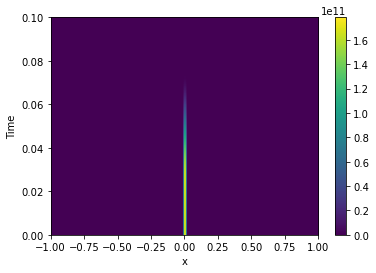

In [53]:
''' Step 1: Define Relevant constants'''
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 100000 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
k_B = 1.381e-23 # J/K
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.

'''Step 2: Set up and solve PDE'''
# Generate a grid of points with py-pde over which the PDE will be solved
x_bound = 1
grid = pde.CartesianGrid([[-x_bound, x_bound]], [101]) 

# Set-up the initial state of the carrier distribution
def N(alpha, area=1):
    '''
    Calculates the coefficient of a Gaussian curve needed to keep area constant
    under changing width
    '''
    return area*np.sqrt(alpha/np.pi)

alpha = 1e23
delta_p_initial = pde.ScalarField.from_expression(grid, f"{N(alpha)}*exp(-{alpha}*x**2)")

const = {
    "D_p" : D_p,
    "mu_p" : mu_p,
    "E_0" : E_0,
    "tau_p" : tau_p
}

# Create the PDE using py-pde 
eq = pde.PDE({"p": "(D_p*d2_dx2(p)) - (mu_p*E_0*d_dx(p)) - ((1/tau_p)*(p))"}, consts=const)

t_max = 1e-5
dt = t_max*1e-6
storage = pde.MemoryStorage()
solution = eq.solve(delta_p_initial, t_range=t_max, dt=dt, tracker=storage.tracker(0.1))

# Pass the PDE to the py-pde solver and store the results for plotting
'''Step 3: Plot the results'''
pde.plot_kymograph(storage)

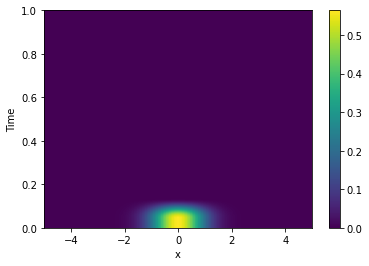

In [34]:
''' Step 1: Define Relevant constants'''
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 100 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
k_B = 1.381e-23 # J/K
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.

'''Step 2: Set up and solve PDE'''
# Generate a grid of points with py-pde over which the PDE will be solved
x_bound = 5
grid = pde.CartesianGrid([[-x_bound, x_bound]], [101]) 

# Set-up the initial state of the carrier distribution
def N(alpha, area=1):
    '''
    Calculates the coefficient of a Gaussian curve needed to keep area constant
    under changing width
    '''
    return area*np.sqrt(alpha/np.pi)

alpha = 1
delta_p_initial = pde.ScalarField.from_expression(grid, f"{N(alpha)}*exp(-{alpha}*x**2)")

# Create the PDE using py-pde 
eq = pde.PDE({"p": f"{D_p}*d2_dx2(p) - {mu_p*E_0}*d_dx(p) - p/{tau_p}"})

# Pass the PDE to the py-pde solver and store the results for plotting
t_max = 1
dt = t_max*1e-6
storage = pde.MemoryStorage()
solution = eq.solve(delta_p_initial, t_range=t_max, dt=dt, tracker=storage.tracker(0.1))
 
'''Step 3: Plot the results'''
pde.plot_kymograph(storage)

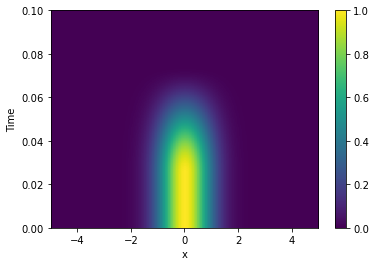

In [15]:
# We can us the py-pde library to solve the differential equation 
import pde 

# Define all the constants in the equation 
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 100 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.

# Set up a grid of cartesian coordinates for the equation to solve
grid = pde.CartesianGrid([[-5, 5]], [101])

# Set up a Scalar Field which will correspond to the excess carriers 
delta_p = pde.ScalarField.from_expression(grid, "exp(-x**2)")
# Now we can encode the partial differential equation (notes below on the formatting)
# eq = pde.PDE({"p": "D_p * d2_dx2(p) - mu_p * E_0 * d_dx(p) - p / tau_p"}, consts=constants)
eq = pde.PDE({"p": f"({D_p}*d2_dx2(p)) - ({mu_p * E_0}*d_dx(p)) - (p / {tau_p})"})
# And solve 
storage = pde.MemoryStorage()
result = eq.solve(delta_p, t_range=0.1, dt = 1e-6, tracker=storage.tracker(0.1))

pde.plot_kymograph(storage)

/opt/anaconda3/envs/physics/lib/python3.9/site-packages/pde/visualization/plotting.py:626: UserWarning: Attempting to set identical bottom == top == 1e-06 results in singular transformations; automatically expanding.
  axes_image = ax.imshow(


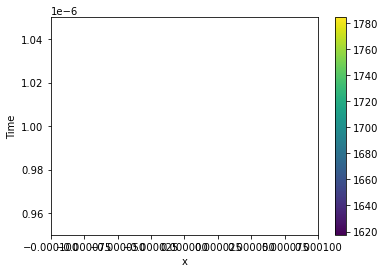

In [55]:
# We can us the py-pde library to solve the differential equation 
import pde 

# Define all the constants in the equation 
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 100 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.

# Set up a grid of cartesian coordinates for the equation to solve
x_bound = 1e-4
grid = pde.CartesianGrid([[-x_bound, x_bound]], [101])

def N(alpha, area=1):
    '''
    Calculates the coefficient of a Gaussian curve needed to keep area constant
    under changing width
    '''
    return area*np.sqrt(alpha/np.pi)

# Set up a Scalar Field which will correspond to the excess carriers 
alpha = 10000000
delta_p = pde.ScalarField.from_expression(grid, f"{N(alpha)}*exp(-{alpha}*x**2)")
# Now we can encode the partial differential equation (notes below on the formatting)
# eq = pde.PDE({"p": "D_p * d2_dx2(p) - mu_p * E_0 * d_dx(p) - p / tau_p"}, consts=constants)
const = {
    "D_p" : D_p,
    "mu_p" : mu_p,
    "E_0" : E_0,
    "tau_p" : tau_p
}

eq = pde.PDE({"p": f"(D_p*d2_dx2(p)) - (mu_p * E_0*d_dx(p)) - (p / tau_p)"}, consts=const)
# And solve 
storage = pde.MemoryStorage()
result = eq.solve(delta_p, t_range=[10*1e-7, 1e-5], dt = 1e-8, tracker=storage.tracker(0.1))

pde.plot_kymograph(storage)

In [13]:
D_p

2.5893749999999996e-05

Now that we've got the general code working, we can use it to explore the scenario set out in the question - largely, that we have $P_0$ = 1 at $x=t=0$

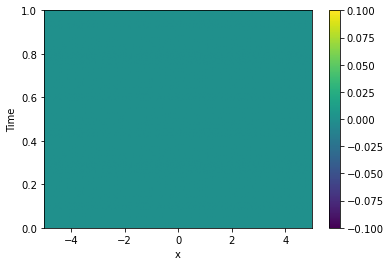

In [52]:
import math 

# Set up the initial grid 
# grid = pde.CartesianGrid([[-1e-10, 1e-10]], [101])
grid = pde.CartesianGrid([[-5, 5]], [101])

# Create an initial delta_p distribution with total carriers P_0 = 1 at x = t = 0

delta_p = pde.ScalarField.from_expression(grid, expression="exp(-1e50*x**2)")

# Solve and display equation solutions 
#eq = pde.PDE({"p": f"{D_p}*d2_dx2(p) - {mu_p * E_0}*d_dx(p) - p / {tau_p}"})
T = 10
E_0 = 10
eq = pde.PDE({"p": f"{T}*d2_dx2(p) - {E_0}*d_dx(p) - p"})

storage = pde.MemoryStorage()
result = eq.solve(delta_p, t_range=1, dt = 1e-6, tracker=storage.tracker(0.2))

pde.plot_kymograph(storage)

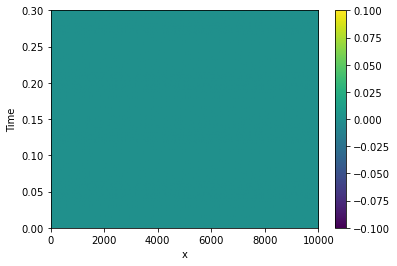

In [50]:
# We can us the py-pde library to solve the differential equation 
import pde 

# Define all the constants in the equation 
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 100 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.

# Set up a grid of cartesian coordinates for the equation to solve
grid = pde.CartesianGrid([[-1e-4, 1e4]], [101])

def N(alpha, area=1):
    '''
    Calculates the coefficient of a Gaussian curve needed to keep area constant
    under changing width
    '''
    return area*np.sqrt(alpha/np.pi)

# Set up a Scalar Field which will correspond to the excess carriers 
alpha = 1e12
coef = N(alpha)
delta_p = pde.ScalarField.from_expression(grid, f"{coef}*exp(-{alpha}*x**2)")
# Now we can encode the partial differential equation (notes below on the formatting)
# eq = pde.PDE({"p": "D_p * d2_dx2(p) - mu_p * E_0 * d_dx(p) - p / tau_p"}, consts=constants)
eq = pde.PDE({"p": "(d2_dx2(p)) - (d_dx(p)) - (p)"})
# And solve 
storage = pde.MemoryStorage()
result = eq.solve(delta_p, t_range=1e5, dt = 1e-8, tracker=storage.tracker(0.1))

pde.plot_kymograph(storage)

/opt/anaconda3/envs/physics/lib/python3.9/site-packages/pde/visualization/plotting.py:626: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes_image = ax.imshow(


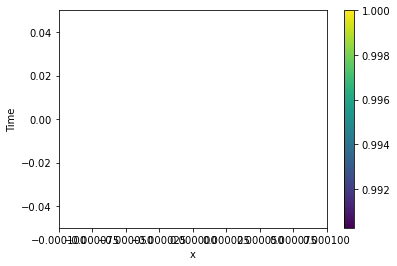

In [59]:
# We can us the py-pde library to solve the differential equation 
import pde 

x_bound = 1e-4
y_bound = 1e-4
dt = y_bound*1e-2

# Define all the constants in the equation 
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 10 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.

# Set up a grid of cartesian coordinates for the equation to solve
grid = pde.CartesianGrid([[-x_bound, x_bound]], [101])

sigma = 1e-6

# Set up a Scalar Field which will correspond to the excess carriers 
#delta_p = pde.ScalarField(grid, data=data)
delta_p = pde.ScalarField.from_expression(grid, f"exp(-x**2/{sigma})")
# Now we can encode the partial differential equation (notes below on the formatting)
# eq = pde.PDE({"p": "D_p * d2_dx2(p) - mu_p * E_0 * d_dx(p) - p / tau_p"}, consts=constants)
eq = pde.PDE({"p": f"{D_p}*(d2_dx2(p)) - {mu_p*E_0}*(d_dx(p)) - (p / {tau_p})"})
# And solve 
storage = pde.MemoryStorage()
result = eq.solve(delta_p, t_range=y_bound, dt = y_bound/100, tracker=storage.tracker(0.1))

pde.plot_kymograph(storage)

Plot the analytic result to see what happens 

In [137]:
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 100 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.
k_B = 1.381E-23 # J/K

def delta_p_analytic(x, t, mu_p=mu_p, D_p=D_p, E_0=E_0, tau_p=tau_p):
    a = np.exp(-t/tau_p)/(4*np.pi*D_p*t)**2
    b = np.exp(-(x-mu_p*E_0*t)**2 / (4*D_p*t))
    return a*b

In [138]:
x_bound = 1e-4
y_bound = 1e-5
dt = y_bound*1e-2

x = np.linspace(-x_bound, x_bound, 101)
y = np.arange(10*dt, y_bound, dt)

X, Y = np.meshgrid(x, y)

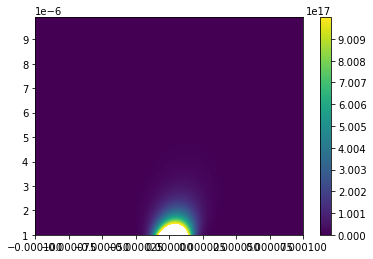

In [139]:
Z = delta_p_analytic(X, Y)

contours = np.linspace(0, 1e18, 1000)

plt.contourf(X, Y, Z, contours)
plt.colorbar()

In [21]:
delta_p_analytic(1e-9, 1e-9)

1.783612039569192e+20